<a href="https://colab.research.google.com/github/abihlo/pinnSWE/blob/main/shallowWaterPINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install pyDOE

In [2]:
import tensorflow as tf
import numpy as np
from pyDOE import lhs
import matplotlib.pyplot as plt 

In [3]:
# Initial condition
u0 = lambda x: 0*x
h0 = lambda x: 0.75+0.25*np.exp(-20*(x-0.1)**2)

# u0 = lambda x: 0.01*np.sin(np.pi*x+0.5)
# h0 = lambda x: 0.75 + 0.25*np.sin(np.pi*x)

# Boundaries of the computational domain
xleft, xright = -1, 1
t0, tfinal = 0, 2

# Gravitational constant
g = tf.constant(1.0, dtype=tf.float32)

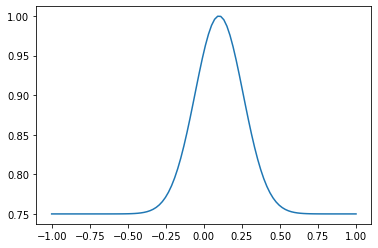

In [4]:
x = np.linspace(xleft, xright, 100)
plt.plot(x, h0(x))

In [5]:
# Define the network
inp1 = tf.keras.layers.Input(shape=(1,))
# b1 = tf.keras.layers.BatchNormalization()(inp1)
inp2 = tf.keras.layers.Input(shape=(1,))
# b2 = tf.keras.layers.BatchNormalization()(inp2)
b = tf.keras.layers.Concatenate()([inp1, inp2])
b = tf.keras.layers.Dense(100, activation='relu')(b)
b = tf.keras.layers.Dense(100, activation='relu')(b)
b = tf.keras.layers.Dense(100, activation='relu')(b)
b = tf.keras.layers.Dense(100, activation='relu')(b)

outu = tf.keras.layers.Dense(1, activation='linear')(b)
outh = tf.keras.layers.Dense(1, activation='relu')(b)

model = tf.keras.models.Model([inp1, inp2], [outu, outh])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 2)            0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 100)          300         concatenate[0][0]            

In [6]:
def PNNtrain(t_bdry, x_bdry, u0, h0, epochs=5000, N_pde=20000, N_iv=1000, N_bv=1000):

  # Optimizer to be used
  opt = tf.keras.optimizers.Adam(
    learning_rate=0.1,
    beta_1=0.99,
    epsilon=1e-1)

  # Sample points where to evaluate the PDE
  tx_min = np.array([t_bdry[0], x_bdry[0]])
  tx_max = np.array([t_bdry[1], x_bdry[1]])  
  pde_points = tx_min + (tx_max - tx_min)*lhs(2, N_pde)
  t_pde = tf.Variable(np.expand_dims(pde_points[:, 0], axis=1)) 
  x_pde = tf.Variable(np.expand_dims(pde_points[:, 1], axis=1))

  # Sample points where to evaluate the initial values
  x_init = np.expand_dims(np.random.uniform(x_bdry[0], x_bdry[1], size=N_iv), axis=1)
  t_init = np.expand_dims(0*x_init, axis=1)
  u_init, h_init = u0(x_init), h0(x_init)

  # Sample points where to evaluate the boundary values
  t_b = np.random.uniform(t_bdry[0], t_bdry[1], size=N_bv)
  t_b = np.expand_dims(np.concatenate((t_b, t_b)), axis=1)
  x_b = np.expand_dims(np.concatenate((x_bdry[0]*np.ones(N_bv),
                           x_bdry[1]*np.ones(N_bv))), axis=1)
 
  # Main training loop
  for i in range(epochs):

    # Outer gradient for tuning network parameters
    with tf.GradientTape() as tape:

      # Inner gradient for derivatives of u wrt x and t
      with tf.GradientTape(persistent=True) as tape2:
        tape2.watch(t_pde)
        tape2.watch(x_pde)
        [u, h] = model([t_pde, x_pde])  
      [dudt, dudx] = tape2.gradient(u, [t_pde, x_pde])
      [dhdt, dhdx] = tape2.gradient(h, [t_pde, x_pde])
      
      # Solve the shallow-water equations
      dudt, dudx = tf.cast(dudt, tf.float32), tf.cast(dudx, tf.float32)
      dhdt, dhdx = tf.cast(dhdt, tf.float32), tf.cast(dhdx, tf.float32)
      
      eqnu = dudt+u*dudx+g*dhdx
      eqnh = dhdt+u*dhdx+h*dudx

      # Define the PDE loss  
      PDEloss = tf.reduce_mean(tf.square(eqnu)) + tf.reduce_mean(tf.square(eqnh))

      # Define the initial and boundary value losses
      [u_init_pred, h_init_pred] = model([t_init, x_init])      
      IVloss = tf.reduce_mean(tf.square(u_init-u_init_pred)) + tf.reduce_mean(tf.square(h_init-h_init_pred))
                              
      [u_b, h_b] = model([t_b, x_b])
      BVloss = tf.reduce_mean(tf.square(u_b[:N_bv]-u_b[N_bv:])) + tf.reduce_mean(tf.square(h_b[:N_bv]-h_b[N_bv:]))

      # Global loss
      loss = PDEloss + IVloss + BVloss

    # Compute the gradient of the global loss wrt the model parameters
    grads = tape.gradient(loss, model.trainable_variables)

    # Gradient step
    opt.apply_gradients(zip(grads, model.trainable_variables))

    if (np.mod(i, 100)==0):
      print("Total loss, PDE loss, IV loss, BV loss in {}th epoch: {: 6.4f}, {: 6.4f}, {: 6.4f}, {: 6.4f}.".format(i, loss.numpy(), PDEloss.numpy(),
                                                                              IVloss.numpy(), BVloss.numpy()))

In [7]:
PNNtrain([t0, tfinal], [xleft, xright], u0, h0)

Total loss, PDE loss, IV loss, BV loss in 0th epoch:  0.6489,  0.0020,  0.6460,  0.0010.
Total loss, PDE loss, IV loss, BV loss in 100th epoch:  0.0183,  0.0006,  0.0175,  0.0002.
Total loss, PDE loss, IV loss, BV loss in 200th epoch:  0.0158,  0.0004,  0.0153,  0.0001.
Total loss, PDE loss, IV loss, BV loss in 300th epoch:  0.0080,  0.0002,  0.0077,  0.0000.
Total loss, PDE loss, IV loss, BV loss in 400th epoch:  0.0057,  0.0003,  0.0054,  0.0000.
Total loss, PDE loss, IV loss, BV loss in 500th epoch:  0.0053,  0.0006,  0.0047,  0.0000.
Total loss, PDE loss, IV loss, BV loss in 600th epoch:  0.0052,  0.0006,  0.0047,  0.0000.
Total loss, PDE loss, IV loss, BV loss in 700th epoch:  0.0049,  0.0005,  0.0044,  0.0000.
Total loss, PDE loss, IV loss, BV loss in 800th epoch:  0.0048,  0.0006,  0.0041,  0.0000.
Total loss, PDE loss, IV loss, BV loss in 900th epoch:  0.0045,  0.0006,  0.0038,  0.0001.
Total loss, PDE loss, IV loss, BV loss in 1000th epoch:  0.0043,  0.0007,  0.0035,  0.0001.


In [8]:
# Grid where to evaluate the model
m, n = 500, 500
t = np.linspace(t0, tfinal, m)
x = np.linspace(xleft, xright, n)
T, X = np.meshgrid(t, x)

dt = t[1]-t[0]

[u, h] = model([np.expand_dims(T.flatten(), axis=1), 
           np.expand_dims(X.flatten(), axis=1)])
u, h = np.reshape(u, (m, n)), np.reshape(h, (m, n))

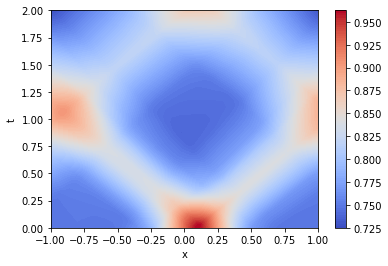

In [9]:
plt.contourf(X, T, h, 100, cmap=plt.cm.coolwarm)
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar()

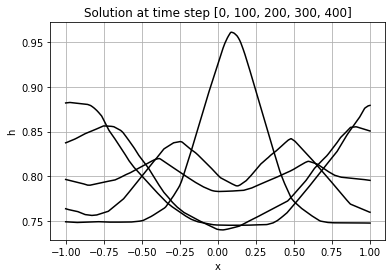

In [10]:
plot_steps = [0, 100, 200, 300, 400]
for i in plot_steps:
  plt.plot(x, h[:,i],'k')
plt.title('Solution at time step {}'.format(plot_steps))
plt.xlabel('x')
plt.ylabel('h')
plt.grid()